In [366]:
!conda init && conda activate makemore

no change     /home/igarg/miniconda3/condabin/conda
no change     /home/igarg/miniconda3/bin/conda
no change     /home/igarg/miniconda3/bin/conda-env
no change     /home/igarg/miniconda3/bin/activate
no change     /home/igarg/miniconda3/bin/deactivate
no change     /home/igarg/miniconda3/etc/profile.d/conda.sh
no change     /home/igarg/miniconda3/etc/fish/conf.d/conda.fish
no change     /home/igarg/miniconda3/shell/condabin/Conda.psm1
no change     /home/igarg/miniconda3/shell/condabin/conda-hook.ps1
no change     /home/igarg/miniconda3/lib/python3.12/site-packages/xontrib/conda.xsh
no change     /home/igarg/miniconda3/etc/profile.d/conda.csh
no change     /home/igarg/.bashrc
No action taken.

CondaError: Run 'conda init' before 'conda activate'



In [367]:
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import torch.nn.functional as F


%matplotlib inline

In [368]:
file_path = Path("names.txt").resolve()

In [369]:
if not file_path.is_file():
    raise FileNotFoundError(f"No file with the name {file_path} is present. Ensure that the file is present before proceeding")

In [370]:
with open(file_path, "r") as f:
    words = f.read().splitlines(keepends=False)

In [371]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [372]:
shape = (27, 27)

In [373]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [374]:
# build the dataset

block_size = 8 # context length: no of chars needed prev to predict next char

X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)


In [375]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 8]), torch.int64, torch.Size([228146]), torch.int64)

In [376]:
# build the dataset

def build_dataset(words):

    block_size = 8 # context length: no of chars needed prev to predict next char

    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(f"{''.join(itos[i] for i in context)} ---> {itos[ix]}")
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


In [377]:
torch.manual_seed(42) # seed rng for reproducibility

In [378]:
import random
random.seed(42)

n1 = int(.8 * len(words))
n2 = int(.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [379]:
for x, y in zip(Xtrain[:20], Ytrain[:20]):
    print("".join(itos[ix.item()] for ix in x), '---->', itos[y.item()])

........ ----> e
.......e ----> m
......em ----> m
.....emm ----> a
....emma ----> .
........ ----> o
.......o ----> l
......ol ----> i
.....oli ----> v
....oliv ----> i
...olivi ----> a
..olivia ----> .
........ ----> a
.......a ----> v
......av ----> a
.....ava ----> .
........ ----> i
.......i ----> s
......is ----> a
.....isa ----> b


In [380]:
class Embedding: # to replicate C (embedding lookup table) init and emb = C[xb]
    def __init__(self, vocab_size: int, embed_size: int):
        self.weight = torch.randn((vocab_size, embed_size)).float()
    
    def __call__(self, IX: torch.Tensor) -> torch.Tensor:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self) -> List[torch.Tensor]:
        return [self.weight]

In [381]:
class Flatten: # to replicate emb.view(emb.shape[0], -1)
    def __call__(self, x:torch.Tensor) -> torch.Tensor:
        self.out = x.view(x.shape[0], int(block_size / 2), -1)
        return self.out

    def parameters(self) -> List:
        return []

class FlattenConsecutive: # flattens out n consecutive elements along a dim
    def __init__(self, n: int):
        self.n = n
    def __call__(self, x:torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self) -> List:
        return []

In [382]:
class Linear: # torch.nn.Linear
    def __init__(self, fan_in: torch.Tensor, fan_out: torch.Tensor, bias: bool = True) -> None:
        self.weight: torch.Tensor = torch.randn((fan_in, fan_out))
        self.weight = self.weight / (fan_in ** 0.5) # gain initialization (kaiming init)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # print(x.shape, self.weight.shape)
        self.out = x @ self.weight
        if self.bias is not None:
            # print(self.out.shape)
            self.out += self.bias

        return self.out
    
    def parameters(self) -> List:
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [383]:
class BatchNorm1d:
    def __init__(
        self,
        num_features: int,
        eps: float = 1e-5,
        momentum: float = 0.1,
        affine=True,
        track_running_stats=True,
    ) -> None:
        # initialization
        self.eps = eps
        self.momentum = momentum
        self.training = True  # different behaviours during training and evaluation such as optim of gamma & beta during training but not during eval

        # params (trained w. backprop update)
        self.gamma = torch.ones((num_features))
        self.beta = torch.zeros((num_features))

        # buffers (trained w. running momentum update)
        self.running_mean = torch.zeros(num_features)
        self.running_variance = torch.ones(num_features)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            mean = x.mean(dim, keepdim=True) # batch mean
            variance = x.var(dim, keepdim=True) # batch variance
        else:
            mean = self.running_mean
            variance = self.running_variance
        
        xhat = (x - mean) / torch.sqrt(variance + self.eps)
        self.out = xhat * self.gamma + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * variance
        
        return self.out
    
    def parameters(self) -> List:
        return [self.gamma, self.beta]

        



In [384]:
class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = F.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [385]:
class Sequential:
    def __init__(self, layers: List[torch.Tensor]):
        self.layers = layers

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [386]:
n_embed = 24
n_hidden = 128
block_size = 8
inner_batch_dim = 2

In [387]:
# # C = torch.randn((vocab_size, n_embed)).float()
# model = Sequential(
#     [
#         Embedding(vocab_size, n_embed),
#         # Flatten(),
#         FlattenConsecutive(inner_batch_dim),
#         Linear(inner_batch_dim * n_embed, n_hidden, bias=False), # (n_embed * block_size) / (block_size / 2) # (can also think of it as 2 examples only)
#         BatchNorm1d(n_hidden),
#         Tanh(),  # input_layer
#         # Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#         # Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
#         # Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
#         # Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
#         Linear(n_hidden, vocab_size),  # output layer
#     ]
# )

In [388]:
# C = torch.randn((vocab_size, n_embed)).float()
model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(inner_batch_dim), Linear(inner_batch_dim * n_embed, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(inner_batch_dim), Linear(inner_batch_dim * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(inner_batch_dim), Linear(inner_batch_dim * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

In [389]:
# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # make last layer less confident

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters =  model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


### Debugging Stuff Below, commented out, uncomment to play

In [390]:
# ix = torch.randint(0, Xtrain.shape[0], (4, )) # batch size: 4
# Xb, Yb = Xtrain[ix], Ytrain[ix]
# logits = model(Xb)
# print(Xb.shape)
# Xb

In [391]:
# model.layers[0].out.shape # embedding layer

In [392]:
# model.layers[1].out.shape # flatten layer

In [393]:
# model.layers[2].out.shape # linear layer

In [394]:
# # what happens inside Linear layer in MLP case:
# ((torch.randn(4, 80) @ torch.randn(80, 200)) + torch.randn(200)).shape # [4, 200] -> [batch_size, n_hidden]
# # right now, the linear layer multiplies all the characters of an example with the weight matrix, effectively multiplying 80 numbers. each character is 10-dim.
# # we want to change that to the following: (1 2) (3 4) (5 6) (7 8)
# # basically, we want to group our 8-char example to pairs of bigrams, and then in the 1st linear layer, just multiply these bigrams.
# # don't want to congest all 80 characters in 1 linear layer
# # so currently we do (4, 80) X (80, 200)
# # but, now since we want to multiply only 2 characters at a time, we want the common dimension to be 2x10 = 20 (10-dim character)
# # so x@W+b, x would become (4,4,20) and W shape -> (20, 200)
# # something similar to
# ((torch.randn(4, 4, 20) @ torch.randn(20, 200)) + torch.randn(200)).shape # [4, 4, 200] # [batch_size, block_size/2, n_hidden]
# # to generate X's similar to above, need to change Flatten layer logic
# # would also have to change weight matrix shape to make it multiplicable

In [395]:
# for layer in model.layers:
#     print(f"{layer.__class__.__name__}: {tuple(layer.out.shape)}")

In [396]:
# e = torch.randn(32, 4, 68) 
# mean = e.mean((0, 1), keepdim=True).squeeze() # (1, 4, 68)
# var = e.var((0, 1), keepdim=True, unbiased=True).squeeze() # (1, 4, 68)
# ehat = (e - mean) / torch.sqrt((var + 1e-5)) # (32, 4, 68)
# e.shape, mean.shape, var.shape, ehat.shape

In [397]:
n_epochs = 200_000
batch_size = 32

lossi = []
ud = []  # update:data ratio at each step

for i in range(n_epochs):
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    x = Xtrain[ix]
    # emb = C[Xtrain[ix]] # moved to layers

    # forward pass
    # x = emb.view(emb.shape[0], -1) # moved to layers
    # for layer in layers:
    #     x: torch.Tensor = layer(x)
    logits = model(x)
    loss: torch.Tensor = F.cross_entropy(logits, Ytrain[ix])

    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad()  ## DEBUG: won't be present in regular training
    for p in parameters:
        p.grad = None  # zero grad

    loss.backward()

    # update
    lr = 10**-1 if i < 150_000 else (10**-2)
    for pi, p in enumerate(parameters):
        # try:
        p.data += -lr * p.grad
    # except Exception as e:
    #     print(i, pi, p.grad)
    #     raise e

    # track stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )  # taking log10 to just see the exponents for better viz

    if i % 10_000 == 0:
        print(f"Step {i} / {n_epochs}: Loss: {loss:.4f}")

    # if i > 1000:  ## DEBUG: Need to track something so just running until n-th epoch
    #     break  ## DEBUG: Need to track something so just running 1 epoch

Step 0 / 200000: Loss: 3.2929


Step 10000 / 200000: Loss: 2.0977
Step 20000 / 200000: Loss: 1.8548
Step 30000 / 200000: Loss: 2.0830
Step 40000 / 200000: Loss: 1.8442
Step 50000 / 200000: Loss: 2.0697
Step 60000 / 200000: Loss: 2.0228
Step 70000 / 200000: Loss: 2.0049
Step 80000 / 200000: Loss: 1.9009
Step 90000 / 200000: Loss: 1.6174
Step 100000 / 200000: Loss: 1.8081
Step 110000 / 200000: Loss: 1.6347
Step 120000 / 200000: Loss: 2.2327
Step 130000 / 200000: Loss: 1.7391
Step 140000 / 200000: Loss: 1.6210
Step 150000 / 200000: Loss: 1.9890
Step 160000 / 200000: Loss: 1.8403
Step 170000 / 200000: Loss: 1.8621
Step 180000 / 200000: Loss: 1.5462
Step 190000 / 200000: Loss: 1.8451


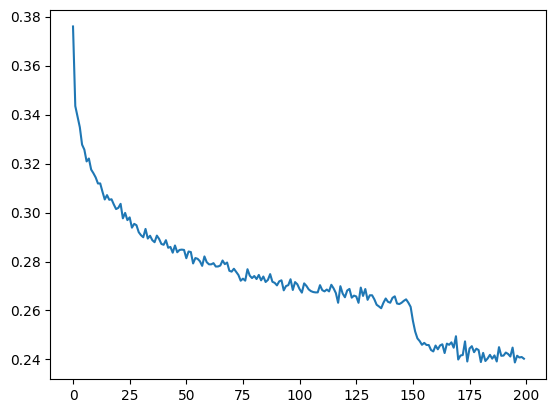

In [398]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [399]:
for layer in model.layers:
    layer.training = False

In [400]:
@torch.no_grad()  # decorator prevents gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (Xtrain, Ytrain),
        "val": (Xval, Yval),
        "test": (Xtest, Ytest),
    }[split]

    logits = model(x)
    loss: torch.Tensor = F.cross_entropy(logits, y)

    print(f"{split} loss = {loss.item()}")


split_loss("train")
split_loss("val")
split_loss("test")

train loss = 1.7217023372650146
val loss = 2.2392168045043945
test loss = 2.287144422531128


In [401]:
# sample from the model

def sample(num_samples: int = 20):
    for _ in range(num_samples):
        samples = []
        context = [0] * block_size # init with all ...
        while True:
            # forward pass the neural net
            x = torch.tensor([context])
            logits = model(x)
            probs = F.softmax(logits)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            samples.append(ix)
            if ix == 0:
                break
        
        print(''.join(itos[i] for i in samples))

sample()

aiyana.
yaid.
jerus.
shanvith.
raylie.
francie.
anaylah.
mccenan.
batori.
brynlee.
shawn.
denice.
myndes.
dayphel.
petrik.
isabellaway.
sahel.
taissa.
mackynzee.
emmilius.


/tmp/ipykernel_2323/1267346133.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)
